# Integer Manipulation - Algorithms
This prjoect looks at the mechanisms for different integer arithmatic by implementing different algorithms for integer manipulation. The initial focus is on the ['Karatsuba Multiplication Algorithm'](https://en.wikipedia.org/wiki/Karatsuba_algorithm). It turns out that multiplication using the algorithm we learned in school (shift across, multiply each digit, carry over, etc) is not the most efficient, especially when dealing with very large integers - such as those used in cryptography.

First, the algorithm is tested out in Python integers. Then, a ```BaseInteger``` class will be developed that will take in different representations and build up to addition, multiplication and subtraction. Various operators, such as +, \*, - will be added. This could be extended with implementing powers and division, and also conversion between different bases.

Further work might incorporate some recent research that has improved the speed of the algorithm to the elusive _O(n log n)_.

## Initial Algorithm
A faster algorithm can be implemented with a 'divide and conquer' approach. We split each of the numbers into two, so that:
\begin{align}
x \times  y &= (x_{1} \times  10^{n} + x_{0}) \times (y_{1} \times  10^{n} + y_{0}) \\
& = x_{1}y_{1} \times  10^{2n} + (x_{1}y_{0} + x_{0}y_{1}) \times 10^{n}) + x_{0}y_{0} \\
& = z_{2} \times  10^{2n} + z_{1} \times 10^{n} + z_{0} \\
\end{align}
where,
\begin{align}
z_{2} &= x_{1}y_{1} \\
z_{1} &= x_{1}y_{0} + x_{0}y_{1} \\
z_{0} &= x_{0}y_{0}
\end{align}

Karatsuba further recognised that these 4 multiplications could be reduced to 3 multiplications, because:
\begin{align}
z_{1} &= (x_{1} + x_{0})(y_{1} + y_{0}) - z_{2} - z_{0}
\end{align}

Note also that these are in base 10, but any base could be used.

### Splitting at 'n/2'
The first implementation of the algorithm using Python modular division. The ```split_at``` function will help to do the split the number at a given number of digits. e.g. 123987 split at 3 digits will give 123 and 987

In [109]:
def split_at(num,digits):
    return (num//digits, num % digits)

In [110]:
import math
print(split_at(123456,10**3))
print(split_at(123456,10**4))
print (math.log10(1_234_567_890)//2+1)
print(split_at(1_234_567_890,10**(math.ceil(math.log10(1_234_567_890))//2)))

(123, 456)
(12, 3456)
5.0
(12345, 67890)


### Initial version of Karatsuba
Now, here's a first implementation, using log10 from the Python math library to find the best split point for now. Later, this will be replaced, but for now it gives a quick way to find 'n/2', where n is the number of digits.

In [111]:
def RecursiveIntegerMultiply(x, y):
    # If one is under 10, this is the base case:
    if (x < 10) or (y < 10):
        return x * y

    # Find the number of (base 10) digits:
    m = int(math.log10(max(x,y))//2+1)
    split_mult = 10**m
    
    high_x,low_x = split_at(x,split_mult)
    high_y,low_y = split_at(y,split_mult)

    z2 = RecursiveIntegerMultiply(high_x,high_y)
    z1 = RecursiveIntegerMultiply(high_x+low_x, high_y+low_y)
    z0 = RecursiveIntegerMultiply(low_x,low_y)

    return z2*(split_mult**2)+(z1-z2-z0)*split_mult+z0

In [112]:
print(RecursiveIntegerMultiply(1000,1000))

1000000


In [113]:
for x,y in (123456789,987654321), \
           (123456789123456789123456789123456789,987654321987654321987654321), \
           (987654321987654321987654321123456789123456789123456789123, \
            987654321987654321987654321123456789123456789123456789123):
    print("Python:  ",x*y)
    print("Function:",RecursiveIntegerMultiply(x,y), end='\n\n')


Python:   121932631112635269
Function: 121932631112635269

Python:   121932631356500531591068431703703700581771069347203169112635269
Function: 121932631356500531591068431703703700581771069347203169112635269

Python:   975461059740893159506325257564700502268404202972107904421746680684042979980339279277425090639992990874560891109129
Function: 975461059740893159506325257564700502268404202972107904421746680684042979980339279277425090639992990874560891109129



## Implementation of BaseInteger class with add() for addition
This class will implement the ```add()``` method for addition, as well as initialising with a number as a string. Representing a number as a string means we can easily add different bases (e.g. hex) later. The ```__str__``` method ensures the number can be printed easily.

Internally, the design uses an integer array, with the digits in reverse order - so '125' is stored as \[5, 2, 1\]. This makes addition and carry over easier, as if we carry over to a higher digit, it can be added easily. The array used is a numpy array set to be int8. Although this implementation will not be 'blazing fast', at least this gives a fast underlying mechanism as numpy is fast and uses fixed areas in memory for the numbers. It also allows for easy implementation of the 'split_at' function and a 'shift' left/right function later.

In [114]:
import numpy as np
class BaseInteger():
    def __init__ (self, x):
        x = x.lstrip('0')
        if len(x) < 1: x = '0'
        self._number = np.zeros(len(x), dtype=np.int8)
        i = 0
        for digit in reversed(x):
            self._number[i] = int(digit)
            i += 1

    def __str__ (self):
        return ''.join(map(str,reversed(self._number.tolist())))
        
    def add (self, other):
        shorter,longer = self._number, other._number
        if len(shorter)>len(longer):
            longer,shorter = shorter,longer

        result = np.zeros(len(longer)+1,dtype=np.int8)
        carry = 0
        for digit in range(len(shorter)):
            add = shorter[digit]+longer[digit]+carry
            result[digit]=add%10
            carry = add//10
        for digit in range(len(shorter),len(longer)):
            add = longer[digit]+carry
            result[digit]=add%10
            carry = add//10
        if carry > 0:
            result[digit]=carry
            
        return BaseInteger(''.join(map(str,reversed(result))))


In [115]:
for test1, test2 in ('51231235234', '0'), ('51231235234', '51231235234'):
    int1 = BaseInteger(test1)
    int2 = BaseInteger(test2)
    res = int1.add(int2)
    print (int1, '+', int2, '=', res)

51231235234 + 0 = 51231235234
51231235234 + 51231235234 = 12462470468


## Implementing multiply() and adding support for different bases
The first implementation of the multiply. Note that this is not Karatsuba, as there isn't a subtract method to use! Still, the code checks for this and uses the longer, 4-multiplication mechanism otherwise.

Bases are implemented up to base 36. This is chosen, because the digits 0-9 plus letters A-Z allow 36 unique digits. Everything is changed to upper case. Note that multiplying/adding between bases works if the target bases get 'smaller', but the algorithm doesn't correctly deal with 'carryunder' yet - when the bases get larger and so need adjusting for higher digits to be represented correctly.

The constructor also adds support for string, numpy arrays and integers to be passed in.

In [116]:
import numpy as np

class BaseInteger():
    def __init__ (self, x, base=10):
        self._base = base
        if isinstance(x,(np.ndarray,)):
            self._number = x.copy()
            # In case we copy a zero-length array, add one digit (a zero)
            # This was an error found during testing with random numbers (speed test)
            if len(x) < 1:
                self._number = np.zeros(1, dtype=np.int16)
        elif isinstance(x,(np.int,int)):
            self._number = np.asarray((x,),dtype=np.int16)
        else:
            if len(x) < 1:
                self._number = np.zeros(1, dtype=np.int16)
            elif (base <= 10): # string assumed!
                self._number = np.array(list(map(int,reversed(x))), dtype=np.int16)
            else: # could have characters in there.
                self._number = np.array(list(map(lambda x: (ord(x) - 48) if 48 <=ord(x)<=57 else ord(x)-65+10,reversed(x.upper()))), dtype=np.int16)

        # Calculate any carryovers
        if len(self._number) > 0:
            self._number = self.propogate_carryovers(self._number,base)
        else:
            print ('empty init', self._number, base, x)
            raise Exception("Zero length")

        # Clean up any leading zeros:
        while len(self._number) > 1 and self._number[-1] == 0:
            self._number = np.delete(self._number, -1)
        # And a sanity check that all digits are less than the base number
        assert (self._number[self._number[:] >= base].sum() == 0), "Overflow - digit out of range."

    def __str__ (self):
        if (self._base <= 10):
            return ''.join(map(str,reversed(self._number.tolist())))
        else:
            return ''.join(map(lambda x: str(x) if x < 10 else chr(65+x-10), reversed(self._number.tolist())))
        
    def get_longer_shorter(self,x,y):
        if len(x)>len(y):
            return x,y
        return y,x

    def propogate_carryovers(self,result,base):
        # Calculate any carryovers
        for digit in range(0,len(result)-1):
            result[digit+1] += result[digit]//base
            result[digit] %= self._base

        while result[-1]>=self._base:
            result = np.append(result, [result[-1]//self._base])
            result[-2] %= self._base

        return result

    def shift (self, shift_num):
        result = BaseInteger(self._number,self._base)
        if shift_num == 0:
            return result
        elif shift_num > 0:
            result._number = np.append(np.zeros(shift_num, dtype=np.int16),result._number)
        elif len(result._number) + shift_num > 0:
            result._number = np.delete(result._number,range(0,-shift_num))
        else:
            return BaseInteger(0,self._base)
        return result

    def add (self, other):
        longer,shorter=self.get_longer_shorter(self._number,other._number)
        # Add the digits
        result = shorter[:] + longer [:len(shorter)]
        result = np.append(result, longer[len(shorter):])

        # Calculate any carryovers
        result = self.propogate_carryovers(result,self._base)
            
        return BaseInteger(result,self._base)


    def multiply(self, other):
        longer,shorter=self.get_longer_shorter(self._number,other._number)
        # If one is single digit, this is the base case:
        if len(shorter) == 1:
            return BaseInteger(longer[:] * shorter[0],self._base)

        # Split the digits into two halves:
        m = len(longer) >> 1 # divide by 2
        if len(shorter) == 1:
            return BaseInteger(longer[:] * shorter[0],self._base)
        b = BaseInteger(longer[:m],self._base)
        a = BaseInteger(longer[m:],self._base)
        d = BaseInteger(shorter[:m],self._base)
        c = BaseInteger(shorter[m:],self._base)

        z2 = a.multiply(c)
        z0 = b.multiply(d)
        subtract = getattr(self, "subtract", None)
        if callable(subtract):
            # If the subtract function has been implemented,
            # use the version with 3 recursive calls and subtractions
            z1 = (a.add(b)).multiply(c.add(d))
            return z2.shift(2*m)+(z1-z2-z0).shift(m)+z0
        else:
            # Otherwise use the version with 4 recursive calls and additions
            z1a = a.multiply(d)
            z1 = b.multiply(c)
            return z2.shift(2*m).add((z1.add(z1a)).shift(m)).add(z0)


In [117]:
# Test cases
print ("Testing BaseInteger class - base 10")
for x,y in ('0','0'), ('1','1'), ('1','10'),('9','9'), ('1000','999'), \
           ('9999999','9999999'), ('9999999','1'), ('1', '9999999'), ('9999999','0'), \
           ('987654321987654321987654321987654321987654321','9'), \
           ('987654321987654321987654321987654321987654321',
            '987654321987654321987654321987654321987654321'):
    x_test = BaseInteger(x)
    y_test = BaseInteger(y)
    result = x_test.add(y_test)
    print ("Adding:",x,'+',y,'=',result, '- Result same as python:', \
           (int(x)+int(y) == int(result.__str__())) )

print ("\nTesting digit shift algorithm")
shifty = BaseInteger(2)
print('Shift 2 left 1:',shifty.shift(1))
print('Shift 2 left 5:',shifty.shift(5))
print('Shift 2 right 1:',shifty.shift(-1))
print('Shift 1000 right 3:',BaseInteger(1000).shift(-3))
print('Shift 2 left 5 and right 1:',shifty.shift(5).shift(-4))

print ("\nTesting Karatsuba multiplication algorithm")
for x,y in ('0','0'), ('1','1'), ('1','10'),('9','9'), ('1000','999'), \
           ('9999999','9999999'), ('9999999','1'), ('1', '9999999'), ('9999999','0'), \
           ('987654321987654321987654321987654321987654321','9'), \
           ('987654321987654321987654321987654321987654321',
            '987654321987654321987654321987654321987654321'):
    x_test = BaseInteger(x)
    y_test = BaseInteger(y)
    result = x_test.multiply(y_test)
    print ("Multiplying:",x,'x',y,'=',result, '- Result same as python:', \
           (int(x)*int(y) == int(result.__str__())) )
print ()
print('Testing alternative bases:')
print(BaseInteger('100',base=2))
print(BaseInteger('100',base=2).add(BaseInteger('100',base=2)))
print(BaseInteger('10000',base=2).add(BaseInteger('100101',base=2)))
print(BaseInteger('111',base=2).add(BaseInteger('111',base=2)),bin(7),bin(7+7))
print(BaseInteger('111',base=2).multiply(BaseInteger('111',base=2)),bin(7),bin(7*7))
print('  ',BaseInteger('11110100001000111111',base=2).multiply(BaseInteger('11110100001000111111',base=2)),bin(999999),"\n",bin(999999*999999))
print(BaseInteger('123434561',base=8).multiply(BaseInteger('234267123',base=8)))
print('  ',BaseInteger('A',base=16).multiply(BaseInteger('A',base=16)), hex(100))
print('  ',BaseInteger('BADF00D',base=16).multiply(BaseInteger('BADF00D',base=16)))
print('  ',BaseInteger('FFFF',base=16).add(BaseInteger('FFFF',base=16)))
print('  ',BaseInteger('FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF',base=16).add(BaseInteger('FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF',base=16)))
print('  ',BaseInteger('FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF',base=16).multiply(BaseInteger('FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF',base=16)))

print('  ',BaseInteger('ABCDEFGHIJKLMNOPQRSTUVWXYZ',base=26).add(BaseInteger('ABCDEFGHIJKLMNOPQRSTUVWXYZ',base=26)))
print('  ',BaseInteger('ABCDEFGHIJKLMNOPQRSTUVWXYZ',base=26).multiply(BaseInteger('ABCDEFGHIJKLMNOPQRSTUVWXYZ',base=26)))
print('  ',BaseInteger('ABCDEFGHIJKLMNOPQRSTUVWXYZ'[::-1],base=26).multiply(BaseInteger('ABCDEFGHIJKLMNOPQRSTUVWXYZ'[::-1],base=26)))

Testing BaseInteger class - base 10
Adding: 0 + 0 = 0 - Result same as python: True
Adding: 1 + 1 = 2 - Result same as python: True
Adding: 1 + 10 = 11 - Result same as python: True
Adding: 9 + 9 = 18 - Result same as python: True
Adding: 1000 + 999 = 1999 - Result same as python: True
Adding: 9999999 + 9999999 = 19999998 - Result same as python: True
Adding: 9999999 + 1 = 10000000 - Result same as python: True
Adding: 1 + 9999999 = 10000000 - Result same as python: True
Adding: 9999999 + 0 = 9999999 - Result same as python: True
Adding: 987654321987654321987654321987654321987654321 + 9 = 987654321987654321987654321987654321987654330 - Result same as python: True
Adding: 987654321987654321987654321987654321987654321 + 987654321987654321987654321987654321987654321 = 1975308643975308643975308643975308643975308642 - Result same as python: True

Testing digit shift algorithm
Shift 2 left 1: 20
Shift 2 left 5: 200000
Shift 2 right 1: 0
Shift 1000 right 3: 1
Shift 2 left 5 and right 1: 20

T

## Adding infix operators
We now update our implementation to add infix operators. The functions to do this are listed in the [Python 3 documentation on emulating numeric types](https://docs.python.org/3/reference/datamodel.html#emulating-numeric-types)

In [118]:
# Create a new class that extends the BaseInteger class and adds in the operator support for + and *
class BaseInteger2(BaseInteger):
    def __init__ (self, x, base=10):
        super().__init__(x,base)

    def __add__(self, other):
        return self.add(other)
    def __mul__(self, other):
        return self.multiply(other)
        

In [119]:
# Test cases
print ("Testing + infix operator for BaseInteger2 class")
for x,y in ('0','0'), ('1','1'), ('1','10'),('9','9'), ('1000','999'), \
           ('9999999','9999999'), ('9999999','1'), ('1', '9999999'), ('9999999','0'), \
           ('987654321987654321987654321987654321987654321','9'), \
           ('987654321987654321987654321987654321987654321',
            '987654321987654321987654321987654321987654321'):
    x_test = BaseInteger2(x)
    y_test = BaseInteger2(y)
    result = x_test + y_test
    print ("Adding:",x,'+',y,'=',result, '- Result same as python:', \
           (int(x)+int(y) == int(result.__str__())) )

#print ("\nTesting digit shift algorithm")
#shifty = BaseInteger2(2)
# Implement __rshift__ for >> and __lshift__ for <<
#print('Shift 2 left 1:',shifty.shift(1))
#print('Shift 2 left 5:',shifty.shift(5))
#print('Shift 2 right 1:',shifty.shift(-1))
#print('Shift 1000 right 3:',BaseInteger(1000).shift(-3))
#print('Shift 2 left 5 and right 1:',shifty.shift(5).shift(-4))

print ("\nTesting * infix operator - uses Karatsuba multiplication algorithm")
for x,y in ('0','0'), ('1','1'), ('1','10'),('9','9'), ('1000','999'), \
           ('9999999','9999999'), ('9999999','1'), ('1', '9999999'), ('9999999','0'), \
           ('987654321987654321987654321987654321987654321','9'), \
           ('987654321987654321987654321987654321987654321',
            '987654321987654321987654321987654321987654321'):
    x_test = BaseInteger2(x)
    y_test = BaseInteger2(y)
    result = x_test * y_test
    print ("Multiplying:",x,'x',y,'=',result, '- Result same as python:', \
           (int(x)*int(y) == int(result.__str__())) )
print ()
print('Testing alternative bases:')
print(BaseInteger2('100',base=2))
print(BaseInteger2('100',base=2) + BaseInteger2('100',base=2))
print(BaseInteger2('10000',base=2) + BaseInteger2('100101',base=2))
print(BaseInteger2('111',base=2) + BaseInteger2('111',base=2),bin(7),bin(7+7))
print(BaseInteger2('111',base=2) * BaseInteger2('111',base=2),bin(7),bin(7*7))
print('  ',BaseInteger2('11110100001000111111',base=2) * BaseInteger2('11110100001000111111',base=2),bin(999999),"\n",bin(999999*999999))
print(BaseInteger2('123434561',base=8) * BaseInteger2('234267123',base=8))
print('  ',BaseInteger2('A',base=16) * BaseInteger2('A',base=16)), hex(100)
print('  ',BaseInteger2('BADF00D',base=16) * BaseInteger2('BADF00D',base=16))
print('  ',BaseInteger2('FFFF',base=16) + BaseInteger2('FFFF',base=16))
print('  ',BaseInteger2('FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF',base=16) + BaseInteger2('FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF',base=16))
print('  ',BaseInteger2('FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF',base=16) * BaseInteger2('FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF',base=16))

print('  ',BaseInteger2('ABCDEFGHIJKLMNOPQRSTUVWXYZ',base=26) + BaseInteger2('ABCDEFGHIJKLMNOPQRSTUVWXYZ',base=26))
print('  ',BaseInteger2('ABCDEFGHIJKLMNOPQRSTUVWXYZ',base=26) * BaseInteger2('ABCDEFGHIJKLMNOPQRSTUVWXYZ',base=26))
print('  ',BaseInteger2('ABCDEFGHIJKLMNOPQRSTUVWXYZ'[::-1],base=26) * BaseInteger2('ABCDEFGHIJKLMNOPQRSTUVWXYZ'[::-1],base=26))

Testing + infix operator for BaseInteger2 class
Adding: 0 + 0 = 0 - Result same as python: True
Adding: 1 + 1 = 2 - Result same as python: True
Adding: 1 + 10 = 11 - Result same as python: True
Adding: 9 + 9 = 18 - Result same as python: True
Adding: 1000 + 999 = 1999 - Result same as python: True
Adding: 9999999 + 9999999 = 19999998 - Result same as python: True
Adding: 9999999 + 1 = 10000000 - Result same as python: True
Adding: 1 + 9999999 = 10000000 - Result same as python: True
Adding: 9999999 + 0 = 9999999 - Result same as python: True
Adding: 987654321987654321987654321987654321987654321 + 9 = 987654321987654321987654321987654321987654330 - Result same as python: True
Adding: 987654321987654321987654321987654321987654321 + 987654321987654321987654321987654321987654321 = 1975308643975308643975308643975308643975308642 - Result same as python: True

Testing * infix operator - uses Karatsuba multiplication algorithm
Multiplying: 0 x 0 = 0 - Result same as python: True
Multiplying: 1

## Speed tests
The Python implementation is expected to be a lot faster than this one. Still, let's see:

In [120]:
# First, we'll implement this function so that we can override
# the method to return a different version of the BaseInteger
# class later, as features are added. This will be like an
# object factory model, providing different versions as needed.
# For now, we return nothing, which would delibrately cause a failure.
def get_base_integer(digits, base=10):
    return None
# Generate numbers with 50, 100, 150, 200, 250 and 300 digits
def do_speed_test(step, top, check_products=False, base=10):
    results = []
    for num_digits in range (step, top+step, step):
        print(f'Number Length: {num_digits}')
        # Create a set of random digits of the required length:
        digits = np.random.randint(0,9,num_digits)
        py_num = 0

        # The BaseInteger class can initialise from an np_array, as it uses these
        # internally. But they are stored 'big endian' (lowest digit first).
        bi_num = get_base_integer(digits, base)
        
        # Turn these into a python integer, and we do this 'little endian':
        for digit in digits[::-1]:
            #print(py_num, "plus", int(digit))
            py_num *= 10 # Shift up one place
            py_num += int(digit) # Add the next digit
        print("> Test number:", py_num)

        # Check we have the same numbers. Note the casts to get an integer.
        if py_num - int(str(bi_num)) != 0:
            print("> Error - numbers are different.")

        # Use the timeit magic and note the result
        py_result = %timeit -n10 -o (py_num*py_num)
        bi_result = %timeit -n1 -r1 -o (bi_num * get_base_integer(digits))
        if check_products:
            if py_num*py_num - int(str(bi_num * get_base_integer(digits))) != 0:
                print("> Error - products are different.")
                print(py_num*py_num)
                print(bi_num * get_base_integer(digits))
            else:
                print("> OK: products match.")

        # Print out the difference in speed and store in our results array.
        print(f'Number Length {num_digits}: Python is {bi_result.best/py_result.best:,.0f} times faster.\n')
        results.append(bi_result.best/py_result.best)
    return results

In [122]:
# First - redefine the 'object factory' to give our BaseInteger2 object.
def get_base_integer(digits, base=10):
    return BaseInteger2(digits)

step = 10
top = 100
results_1 = do_speed_test(step, top)


Number Length: 10
> Test number: 2315837530
483 ns ± 61.8 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
15.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 10: Python is 34,729 times faster.

Number Length: 20
> Test number: 54666187162137636621
240 ns ± 65.5 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
50.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 20: Python is 241,161 times faster.

Number Length: 30
> Test number: 71472651280124603433811030778
283 ns ± 44.6 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
113 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 30: Python is 453,286 times faster.

Number Length: 40
> Test number: 2403770350216181564287860465280645287063
426 ns ± 79.8 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
209 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 40: Python is 549,603 times faster.

Number Length: 50
> Test

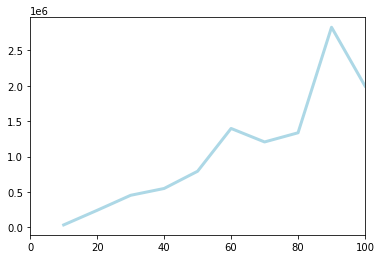

In [123]:
# Now plot the results
import matplotlib
import matplotlib.pyplot as plt
plt.plot(range (step, top+step, step), results_1, color='lightblue', linewidth=3)
plt.xlim(0, top)
plt.show()

#### Notes on comparison
In fact, our implementation is millions of times slower, but at least it seems that things equal out as we get to multiplying numbers with over 500 digits. The test will be run again once the subtract() has been implemented, which should show an improvement with 25% less recursive calls.

## Subtract() and negative numbers
Implementing subtract also means supporting negative numbers. Once subtract is implemented, retest the multiplication mechanism as it will use the Karatsuba version when it detects a subtract function.

### Negative number support
Considerations:
- implement as a 'negative' Boolean value
- init() needs to detect this for:
    - string input
    - integer input
    - direct flag when passing in arguments, which will combine with:
    - np_array -> the negative flag will be passed in addition
- multiply() -> two signs the same give a positive, two signs different give a negative, so:
    - we will mark this as a private function, \_multiply() and ignore sign there
    - we can then deal with the sign in the * operator handler
- add() -> adding a negative number can be passed to subtract()
- subtract() -> similarly, subtracting a negative number can be passed to add
- \__str\__() needs to print this
- add implementation for comparison operators: > >= < <= != ==

In [124]:
import numpy as np

# Reimplement the class
class NewBaseInteger:
    
    def __init__ (self, x, base=10, negative=False, store=np.int16):
        self._base = base
        self._negative = negative
        if isinstance(x,(np.ndarray,)):
            self._number = x.copy()
            # In case we copy a zero-length array, add one digit (a zero)
            # This was an error found during testing with random numbers (speed test)
            if len(x) < 1:
                self._number = np.zeros(1, dtype=store)
        elif isinstance(x,(np.int,int)):
            if x < 0:
                x = -x
                self._negative = True
            
            first = True
            while x >= self._base:
                if first:
                    self._number = np.asarray((x % self._base,),dtype=store)
                    first = False
                else:
                    self._number[-1] = x % self._base
                    x //= self._base
                    self._number = np.append(self._number, [x])
        else:
            if x[0] == '-':
                self._negative = True
                x.replace('-','')
            if len(x) < 1:
                self._number = np.zeros(1, dtype=np.store)
            elif (base <= 10): # string assumed!
                self._number = np.array(list(map(int,reversed(x))), dtype=store)
            else: # could have characters in there.
                self._number = np.array(list(map(lambda x: (ord(x) - 48) if 48 <=ord(x)<=57 else ord(x)-65+10,reversed(x.upper()))), dtype=store)

        # Calculate any carryovers
        if len(self._number) > 0:
            self._number, self._negative = self.propogate_carryovers(self._number,base,self._negative)
        else:
            print ('empty init', self._number, base, x)
            raise Exception("Zero length")

        # Clean up any leading zeros:
        while len(self._number) > 1 and self._number[-1] == 0:
            self._number = np.delete(self._number, -1)
        # And a sanity check that all digits are less than the base number
        assert (self._number[self._number[:] >= base].sum() == 0), "Overflow - digit out of range."

    def __str__ (self):
        if (self._base <= 10):
            return ('-' if self._negative else '') + ''.join(map(str,reversed(self._number.tolist())))
        elif (self._base <= 36):
            return ('-' if self._negative else '') + ''.join(map(lambda x: str(x) if x < 10 else chr(65+x-10), reversed(self._number.tolist())))
        elif (self._base in [100,1_000,10_000,1_00_000,1_000_000, 10_000_000,100_000_000,1_000_000_000]):
            result = ('-' if self._negative else '')
            result += str(self._number[-1])
            if len(self._number > 1):
                num = 0
                b = self._base
                while (b > 1):
                    num += 1
                    b //= 10
                result += ''.join([str(x).zfill(num) for x in self._number[-2::-1]])
            return result
        else:
            return ('-' if self._negative else '') + ('|'.join(self._number))

    def get_longer_shorter(self,x,y):
        if len(x)>len(y):
            return x,y
        return y,x

    def propogate_carryovers(self, result, base, negative):
        # Calculate any carryovers
        for digit in range(0,len(result)-1):
            # note, if we come here after subtraction, some digits may be negative
            # the calculation still works, as the // returns a negative, and
            # the % correctly gives the remainder from the carryover number
            result[digit+1] += result[digit]//base
            result[digit] %= self._base
            #print (result[digit],result[digit+1])

        #print(result, self._base)
        if result[-1] < 0:
            result[-2] = result[-1] % self._base
            result[-1] = 0
            negative = not negative
        while result[-1]>=self._base:
            result = np.append(result, [result[-1]//self._base])
            result[-2] %= self._base
            #print (result[-1],result[-2])
            
        return result, negative

    def shift (self, shift_num):
        result = NewBaseInteger(self._number,self._base,self._negative)
        if shift_num == 0:
            return result
        elif shift_num > 0:
            result._number = np.append(np.zeros(shift_num, dtype=store),result._number)
        elif len(result._number) + shift_num > 0:
            result._number = np.delete(result._number,range(0,-shift_num))
        else:
            return NewBaseInteger(0,self._base)
        return result

    
    def add (self, other):
        # Logic for adding or subtracting:
        # 100 + 10 -> 110 (add digits)
        # 100 + (-10) -> 90 (subtract)
        # -100 + 10 -> 90 (subtract: other,self) -> 10 - 100
        # -100 + (-10) -> -110 (add, keep sign)
        if other._negative != self._negative:
            if other._negative:
                return self.subtract(other)
            else:
                return other.subtract(self)

        longer,shorter=self.get_longer_shorter(self._number,other._number)
        # Add the digits
        result = shorter[:] + longer [:len(shorter)]
        result = np.append(result, longer[len(shorter):])

        # Calculate any carryovers
        result, negative = self.propogate_carryovers(result,self._base,self._negative)
            
        return NewBaseInteger(result, self._base, negative)

    def subtract (self, other):
        # Logic for adding or subtracting:
        # 100 - 10 -> 90 (subtract)
        # 100 - (-10) -> 110 (add)
        # -100 - (-10) -> -90 (subtract)
        # -100 - (+10) -> -110 (add, keep sign)
        if other._negative != self._negative:
            return self.add(NewBaseInteger(other._number,other._base, not other._negative))

        sizediff = len(self._number) - len(other._number)
        second = other._number
        negative = False
        
        # Subtract the digits -> may give us negative digits...
        if sizediff >= 0:
            second = np.append(second, np.zeros(sizediff, dtype=store))
            result = self._number -second
        elif sizediff < 0:
            self._number = np.append(self._number, np.zeros(-sizediff, dtype=store))
            result = second - self._number
            negative = True
        #print(self._number)
        #print(second)
        #print(result)

        # Calculate any carryovers - sorting out any negative digits
        result, negative = self.propogate_carryovers(result, self._base, self._negative | negative)
            
        return NewBaseInteger(result, self._base, negative)

    def _multiply(self, other, negative):
        longer,shorter=self.get_longer_shorter(self._number,other._number)
        # If one is single digit, this is the base case:
        if len(shorter) == 1:
            return NewBaseInteger(longer[:] * shorter[0],self._base, negative)

        # Split the digits into two halves:
        m = len(longer) >> 1 # divide by 2
        b = NewBaseInteger(longer[:m],self._base)
        a = NewBaseInteger(longer[m:],self._base)
        d = NewBaseInteger(shorter[:m],self._base)
        c = NewBaseInteger(shorter[m:],self._base)

        z2 = a._multiply(c, negative)
        z0 = b._multiply(d, negative)
        subtract = getattr(self, "subtract", None)
        if callable(subtract):
            # If the subtract function has been implemented,
            # use the version with 3 recursive calls and subtractions
            z1 = (a.add(b))._multiply(c.add(d), negative)
            return z2.shift(2*m)+(z1-z2-z0).shift(m)+z0
        else:
            # Otherwise use the version with 4 recursive calls and additions
            z1a = a._multiply(d, negative)
            z1 = b._multiply(c, negative)
            return z2.shift(2*m).add((z1.add(z1a)).shift(m)).add(z0)
        
    def __add__(self, other):
        return self.add(other)
    def __mul__(self, other):
        return self._multiply(other, (self._negative != other._negative))
    def __sub__(self, other):
        return self.subtract(other)
        

In [125]:
a = 1000
b = -999
i1 = NewBaseInteger(a)
i2 = NewBaseInteger(b)
print(i1, i2, i1 +i2)
print (a + b)

1000 -999 1999
1


In [126]:
a = -1000
b = -999
i1 = NewBaseInteger(a)
i2 = NewBaseInteger(b)
print(i1, i2, i1 * i2)
print (a * b)

-1000 -999 999000
999000


### Speed with Karatsuba
Now that we have implemented subtract, the \_multiply() function will automatically use this to reduced the number of recurive calls. Test if it makes a difference:

In [127]:
def get_base_integer(digits, base=10):
    return BaseInteger2(digits, base)

step = 50
top = 600
results_1 = do_speed_test(step, top, False, 10)

def get_base_integer(digits, base=10):
    return NewBaseInteger(digits,base) # USING KARATSUBA
results_karatsuba = do_speed_test(step, top, False, 10)


Number Length: 50
> Test number: 10460508244082840862483521413278554754617114188266
400 ns ± 69.5 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
329 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 50: Python is 887,861 times faster.

Number Length: 100
> Test number: 7011481318347736726070648213262840677401570213045276053488618626401812141536887856561458438348831066
744 ns ± 80.5 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.27 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 100: Python is 1,818,794 times faster.

Number Length: 150
> Test number: 325773456026035562384330586682257872178118777083165784720858645816788203047856000526827255265021785472376357030800124325873470242001203131785302287574
1.08 µs ± 78.5 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.98 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 150: Python is 2,861,607 times faster.

Number Length: 200
> Test number: 

3.99 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 250: Python is 2,013,750 times faster.

Number Length: 300
> Test number: 74287841803421383756618766751270448488033532415045683685166572683710263205816231512174842756117053665564887476577613866247746485668750415465650643128133744614410236566144883128036334038181787621430785318063045213033762803074223010075326838528454316188453220055745643102158625557344752711100560088048
2.75 µs ± 92.3 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
5.35 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 300: Python is 1,988,596 times faster.

Number Length: 350
> Test number: 6213202112662242264144353170164060756215232604404211037447255520237114002043478357446467478101634000438275347108038348534230041363884550667055202667162083230801586526881865818561524314253733782432730245844135535643754022686275620278381356046060348881826310084114025543422470020751260840644455677734374830267668625887205482151

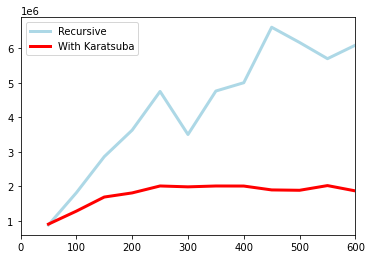

In [128]:

import matplotlib
import matplotlib.pyplot as plt
plt.plot(range (step, top+step, step), results_1, color='lightblue', linewidth=3, label='Recursive')
plt.plot(range (step, top+step, step), results_karatsuba, color='red', linewidth=3, label='With Karatsuba')
plt.xlim(0, top)
plt.legend()
plt.show()

#### Notes on comparison
Certainly the Karatsuba implementation is an improvement with less recursive calls.

## Improving further
The underlying Python implementation uses integer multiplication for shorter numbers (up to arounf 6 or 7 digits long). This is because we can use built-in integers up to 64 bits, which gives us numbers up to 9,223,372,036,854,775,807 - before it runs out of bits and get a binary overflow, where the integers turn negative.

We can implement this using our current class and setting the base to something big - like a million. Now, this is going to be cheating a little, as we're using the Python integer implementation to compare with itself, at least at shorter numbers. But the principle is there, at least.

I will tweak the do_speed_test to create these big base numbers, 

I'll need change the NewBaseInteger implementation, as this uses numpy.int16, which will run out of bits quickly. Instead, we'll default to numpy.int16, and if the base goes above 100, switch to np.int64. That should allow us to pass in digits in blocks of 6 - or 'base 1 million'.

In [129]:
def get_base_integer(digits, base=1000, store=np.int16):
    return NewBaseInteger(digits,base) # USING KARATSUBA + grouping in thousands

# Generate numbers with 50, 100, 150, 200, 250 and 300 digits
def do_speed_test(step, top, check_products=False, base=100):
    store = np.int16
    if base > 100:
        store = np.int64

    results = []
    num_dig_base = 0
    b = base
    while (b > 1):
        num_dig_base += 1
        b //= 10
    for num_digits in range (step, top+step, step):
        print(f'Number Length: {num_digits}')
        # Create a set of random digits of the required length:
        digits = np.random.randint(0,9,num_digits)
        py_num = 0

        # The BaseInteger class can initialise from an np_array, as it uses these
        # internally. But they are stored 'big endian' (lowest digit first).
        big_base_digits = []
        if base > 10:
            for slice in range(0,len(digits)-num_dig_base,num_dig_base):
                temp_num = 0
                for x in range(num_dig_base):
                    temp_num *= 10 # Shift up one place
                    temp_num += int(digits[slice+x]) # Add the next digit
                big_base_digits.append(temp_num)
        else:
            big_base_digits = digits

        # print(big_base_digits)
        bi_num = get_base_integer(np.asarray(big_base_digits,dtype=store), base, store)
        # print(bi_num, bi_num._number, bi_num._base)
        
        # Turn these into a python integer, and we do this 'little endian':
        py_num = int(str(bi_num))
        print("> Test number:", py_num)

        # Check we have the same numbers. Note the casts to get an integer.
        if py_num - int(str(bi_num)) != 0:
            print("> Error - numbers are different.")

        # Use the timeit magic and note the result
        py_result = %timeit -n10 -o (py_num*py_num)
        bi_result = %timeit -n1 -r1 -o (bi_num * get_base_integer(digits))
        if check_products:
            if py_num*py_num - int(str(bi_num * get_base_integer(digits))) != 0:
                print("> Error - products are different.")
                print(py_num*py_num)
                print(bi_num * get_base_integer(np.asarray(big_base_digits,dtype=store), base))
            else:
                print("> OK: products match.")

        # Print out the difference in speed and store in our results array.
        print(f'Number Length {num_digits}: Python is {bi_result.best/py_result.best:,.0f} times faster.\n')
        results.append(bi_result.best/py_result.best)
    return results

Now let's test and plot the results:

In [130]:
results_1000 = do_speed_test(step,top,False,1_000_000)

Number Length: 50
> Test number: 27374852655745202176357170746728886328438168528
394 ns ± 63.9 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
80.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 50: Python is 222,903 times faster.

Number Length: 100
> Test number: 865321804816860163071614468548445786173217755564841160664861263273664550473300764755766800750687
510 ns ± 73.9 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
254 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 100: Python is 540,295 times faster.

Number Length: 150
> Test number: 616461371372323807422062133141266515304460374462476485352680654168600513440341763035718074246016332362100582134776216178338124858734266630010838
990 ns ± 81.8 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
496 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Number Length 150: Python is 522,052 times faster.

Number Length: 200
> Test number: 77122482643217004

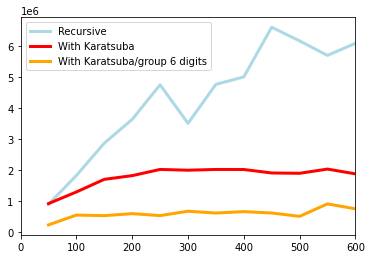

In [131]:

import matplotlib
import matplotlib.pyplot as plt
plt.plot(range (step, top+step, step), results_1, color='lightblue', linewidth=3, label='Recursive')
plt.plot(range (step, top+step, step), results_karatsuba, color='red', linewidth=3, label='With Karatsuba')
plt.plot(range (step, top+step, step), results_1000, color='orange', linewidth=3, label='With Karatsuba/group 6 digits')
plt.xlim(0, top)
plt.legend()
plt.show()

#### Comments
Good that we have gone under 10 seconds for the longest number, and now only 600-700 thousand times slower than Python! Again, we cheated a little by using the integer implementation. But Python does that too! :) 

## Division
A simple implementation would be to repeatedly subtract the number! We'll first try the long division implementation from school. 

## Powers
Implementation of integer powers - including negative ones, which means we need division first.

## Convert Base
Conversion between bases, which would be helped by powers and division mechanisms.

## Final testing and abstraction
